In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from collections import Iterable
import six

In [8]:
""" simple thermal evolution model, isoviscous """

M_E = 5.972e24 # earth mass in kg
R_E = 6371e3 # earth radius in m
L_sun =  3.9e26 # solar luminosity in W
Q_cmb_Earth = 11e12 # heat flux from (Earth's) core in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4
R_b = 8.3144598 # universal gas constant in J mol −1 K −1

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
X_0 = [X_K, X_U, X_U, X_Th]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

L=1 # stellar luminosity in solar units
Alb=0

# thermo/geodynamic parameters
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 3000 #4500 # Density of silicate mantle in kg m^-3
# what pressure should you take these densities at?
eta_m = 10**20 # Pa s, constant, actually eta... i.e. not kinematic viscosity but the other one
Ra_c = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
c_pm = 1200 # in Dorn, Noack & Rozal 2018
#c_pm = 800 # specific heat capacity of silicate material (at constant volume) in J kg−1 K−1 (Elkins-Tanton+ 2011)
# can you use the same c_pm for lid and mantle?
# check if this is the right value for constant volume heat capacity
alpha_m = 2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1
k_lm = 10 # thermal conductivity lower mantle
dT_core = 1000 # temperature jump across CMB in K




def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius_by_v(V):
    return (3*V/(4*np.pi))**(1/3)

def radius_basic(M_p, CRF, rho_m, rho_c):
    """Calculate radius of planet given total mass, assume lid (bndy layer) has the same density as mantle
    
    Parameters
    ----------
    M_p : float
        Mass of planet
    rho_m : float
        Mantle density
    F_c : float
        Core fraction in terms of radius
    rho_c : float
        Core density
    """
    
    R_p = ( 3*M_p/(4*np.pi) / (rho_m - CRF**3*rho_m + CRF**3*rho_c) )**(1/3)
    return R_p

def radius_seager(M_p, CMF=0.3, k1=-0.20945, k2=0.0804, k3=0.394, m1=None, r1=None):
    if (m1 is None) and (r1 is None):
        if CMF==0.3:
            m1 = 6.41*M_E
            r1 = 2.84*R_E
        elif CMF==0.675:
            m1 = 6.41*M_E
            r1 = 3.19*R_E
        elif CMF==0: # all perovskite
            m1 = 7.38*M_E
            r1 = 3.58*R_E
    M_s = M_p/m1
    R_s = 10**(k1 + 1/3*np.log10(M_s) - k2*M_s**k3)
    return R_s*r1

def radius_otegi(M_p):
    return np.exp(1/3.45*np.log(M_p/0.9))

def radius_zeng(M_p, CMF=None):
    # applicable to M_E <= 8 and CMF <= 0.4
    print('using Zeng radius model')
    return (1.07 - 0.21*CMF)*(M_p/M_E)**(1/3.7)

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)

def luminosity(tau, L=None, **kwargs):
    return L
    
def q_star(t=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return luminosity(t, **kwargs)*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    #print('kappa', k/(rho*C_p), 'm^2 s^-1')
    return k/(rho*C_p)

def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

def init(k_m=None, rho_m=None, rho_c=None, c_pm=None, CMF=None, M_p=None, **kwargs):
    R_p = radius_zeng(M_p, CMF)*R_E # in m
    M_m = M_p*(1 - CMF) # mass of mantle
    CRF = CMF**0.5 # Zeng & Jacobsen 2017
    R_c = R_p*CRF
    #R_c = radius_seager(M_p*CMF, CMF=0, m1=4.34*M_E, r1=2.23*R_E) # EoS for iron... is this consistent?
    SA_p = SA(R=R_p)
    SA_c = SA(R=R_c) # core surface area 
    print('SA_c', SA_c)
    print('SA_p', SA_p)
    g_sfc = grav(M_p, R_p)
    if CMF>0:
        g_cmb = grav(M_p*CMF, R_c)
    else:
        g_cmb = 0
    kappa_m = thermal_diffusivity(k_m, rho_m, c_pm)
    return dict(kappa_m=kappa_m, SA_p=SA_p, SA_c=SA_c, M_m=M_m, g_sfc=g_sfc, R_p=R_p, R_c=R_c,
                CRF=CRF, g_cmb=g_cmb)

def Ra(nu=None, eta=None, kappa=None, alpha=None, rho=None, g=None, deltaT=None, l=None):
    if (nu is None) and (eta is not None):
        return rho*alpha*deltaT*l**3*g/(kappa*eta)
    elif (nu is not None) and (eta is None):
        return alpha*deltaT*l**3*g/(kappa*nu)

def bdy_thickness(dT, Ra_c=None, eta_m=None, alpha_m=None, rho_m=None, g=None,
                  kappa_m=None, nu_m=None, **kwargs):
    """Thickness of thermal boundary layer 
    
    Parameters
    ----------
    T_s : float
        Surface temperature
    Ra_c : float
        Critical Rayleigh number
    alpha_m : float 
        Thermal expansivity in
    kappa : float 
        Thermal diffusivity in
    eta : float
        Mantle viscosity in Pa s
    g : float
        Acceleration due to gravity in m s^-2
    
        
    Returns
    -------
    d : float
        Lid thickness in m
    """
    

    # Set Rayleigh number at critical value
    if eta_m is not None:
        d = (Ra_c * eta_m*kappa_m/(alpha_m*rho_m*g*(dT)))**(1/3)
    elif nu_m is not None:
        d = (Ra_c * nu_m*kappa_m/(alpha_m*g*(dT)))**(1/3)
    return d

def visc(T=None, eta_0=None, visc_type=None, **kwargs):
    if visc_type=='const':
        return [eta_0]*len(T)
    elif visc_type=='Dorn':
        return nu_Dorn(T, **kwargs)
    elif visc_type=='KW':
        return nu_KW(T, **kwargs)
    elif visc_type=='Driscoll':
        return nu_Driscoll(T)
    
def nu_Driscoll(T, nu_0=7e7, Ea=3e5):
    """kinematic viscosity (upper mantle) from eqn 6 in Driscoll & Bercovici"""
    return nu_0*np.exp(Ea/(R_b*T))/10

def nu_Dorn(T, nu_0=1.6e20, Ea=300e3, T_0=1800, **kwargs):
    # viscosity (below lithosphere) from Dorn, Noack & Rozal 2018
    return nu_0*np.exp(Ea/R_b*(T**-1-T_0**-1))

def nu_KW(T, p=0, **kwargs): # Karato & Wu 1993, diffusion law for dry olivine
    return 2.6e10*np.exp((3e5 + (6e3*p))/(R_b*T))   

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

def q_sfc_outgoing(R_p=None, SA_p=None, **kwargs):
    return q_star(**kwargs)*(np.pi*R_p**2)/SA_p # assume no geothermal contribution, pi*R^2 cancels out

def h_rad(t=None, tf=None, H_0=None, X_0=None, el_0=None, t_half=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not t_vect:
        return sum(H_0*X_0*el_0*np.exp(-np.log(2)*t/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, val in enumerate(t):
            h[ii] = sum(H_0*X_0*el_0*np.exp(-np.log(2)*val/t_half))
        return h
        
def Q_rad(t=None, M_m=None, **kwargs):
    """Calculate energy flux radioisotope decay in W"""
    h = h_rad(t, **kwargs)
    #print('h =', h, 'W kg^-1 @ t =',t*1e-6/years2sec, 'Myr')
    return h*M_m # mass cancels out

def Q_cmb(SA_c=None, **kwargs):
    """Calculate energy flux from core in W"""
    SA_c_Earth = SA(R=3480e3)
    #q_cmb = Q_cmb_Earth/SA_c_Earth # Heat flux across CMB in W m^-2, use earth value for now
    return q_cmb*SA_c
    
def Q_cond(T_m, k=None, SA=None, dT=None, g=None, **kwargs):
    """Calculate energy flux from conduction across thermal bdy layer in W"""
    v = visc(T_m, **kwargs) # upper mantle viscosity 
    d_lid = bdy_thickness(dT, nu_m=v, g=g, **kwargs)
    return SA*k*dT/d_lid 
    
def dTdt(t, T_m, T_s=None, Q_core=None, M_m=None, c_v=None, dT_core=None, SA_p=None, SA_c=None, 
         g_sfc=None, g_cmb=None, **kwargs):
    """R.H.S. of ODE for mantle temperature change"""
    #print('t, T_m', t, T_m)
    Q_core = Q_cond(T_m, dT=dT_core, k=k_lm, SA=SA_c, g=g_cmb, **kwargs) # Q_cmb(**kwargs)
    return (-Q_cond(T_m, dT=T_m-T_s, k=k_m, SA=SA_p, g=g_sfc, **kwargs) + Q_rad(t, M_m=M_m, **kwargs) + Q_core)/(M_m*c_v)

def solve_Tm(tf=None, T_m0=None, t0=0, plots=False, plots_save=False, fend='', M_p=None, T_s=None, **kwargs):
    derargs = init(M_p=M_p, **kwargs)
    if T_s is None:
        q_out = q_sfc_outgoing(**derargs, **kwargs)
        T_s = T_sfc(q_out)
    M_ME = M_p/M_E
    M_mME = derargs['M_m']/M_E
    print('R_p =', '%.2f'%(derargs['R_p']/R_E), 'R_E')
    print('M_mantle', '%.2f'%M_mME, 'M_E')
    print('g_sfc =', '%.2f'%derargs['g_sfc'], 'm s^-2')
    print('CRF =', '%.2f'%derargs['CRF'])
    print('T_s =', '%.2f'%T_s, 'K')
#     print('Q_cmb', '%.2f'%(Q_core*1e-12), 'TW')
    print('Q_lid(t=0) =', Q_cond(T_m0, k=kwargs['k_m'], SA=derargs['SA_p'], dT=T_m0-T_s, g=derargs['g_sfc'],
                                 **derargs,**kwargs))
    
    f = integrate.solve_ivp(fun=lambda t, y: dTdt(t, y, **dict(T_s=T_s, M_p=M_p, 
                                                  **derargs, **kwargs)), 
                            t_span=(t0,tf), y0=[T_m0], max_step=100e6*years2sec,
                            method='RK45', t_eval=None, dense_output=False, events=None)
    #print(f)
    if plots:
        rad_heating = Q_rad(f.t, t_vect=True, **derargs, **kwargs)
        cond_cooling = Q_cond(f.y[0], dT=f.y[0]-T_s, SA=derargs['SA_p'], k=kwargs['k_m'], 
                              g=derargs['g_sfc'], **derargs, **kwargs)
        core_heating = Q_cond(f.y[0], dT=kwargs['dT_core'], k=kwargs['k_lm'], SA=derargs['SA_c'], 
                              g=derargs['g_cmb'], **derargs,**kwargs)
        urey = rad_heating/cond_cooling
        d_lid = bdy_thickness(dT=f.y[0]-T_s, g=derargs['g_sfc'], nu_m=visc(f.y[0], visc_type='Driscoll'), 
                              **derargs, **kwargs)
        
        fig, axes = plt.subplots(2, 5, figsize=(13,6))
        plot_one(axes[0][0], f.t*1e-6/years2sec, 
                 f.y[0],
                 '', 'Avg mantle temp (K)', xticks=False)
        #plot_structure(axes[0][1], R_p, R_cmb)
        plot_one(axes[0][1], f.t*1e-6/years2sec, 
                 d_lid*1e-3, 
                 '', 'Lid thickness (km)', xticks=False)
        plot_one(axes[0][2], f.t*1e-6/years2sec, 
                 Ra(eta=eta_m, kappa=derargs['kappa_m'], alpha=kwargs['alpha_m'], rho=kwargs['rho_m'],
                    g=derargs['g_sfc'], deltaT=f.y[0]-[T_s]*len(f.y[0]), l=derargs['R_p']*(1-derargs['CRF'])), 
                 '', 'Rayleigh number', xticks=False)
        
        plot_one(axes[1][0], f.t*1e-6/years2sec, 
                 cond_cooling*1e-12, 
                 'Age (Myr)', '$Q_{lid,out}$ (TW)', xticks=True)
        plot_one(axes[1][1], f.t*1e-6/years2sec, 
                 rad_heating*1e-12,
                 'Age (Myr)', '$Q_{rad}$ (TW)', xticks=True)
        plot_one(axes[1][2], f.t*1e-6/years2sec, 
                 urey, 
                 'Age (Myr)', 'Urey ratio', xticks=True)
        plot_one(axes[0][3], f.t*1e-6/years2sec, 
                 cond_cooling/derargs['SA_p'], 
                 '', '$q_{lid,out}$ (W/m$^2$)', xticks=True)
        plot_one(axes[1][3], f.t*1e-6/years2sec, 
                 rad_heating/derargs['M_m']*kwargs['rho_m'],
                 'Age (Myr)', '$q_{rad}$ (W/m$^3$)', xticks=True)
        plot_one(axes[0][4], f.t*1e-6/years2sec, 
                 core_heating*1e-12, 
                 '', '$Q_{cmb}$ (TW)', xticks=True)
        plot_one(axes[1][4], f.t*1e-6/years2sec, 
                 nu_Driscoll(f.y[0]),
                 'Age (Myr)', r'$\nu_{um}$ (m$^2$s$^{-1}$)', xticks=True)
        
        axes[0][0].set_title(str(M_p/M_E)+' M$_E$, CMF='+str(CMF))
        plt.tight_layout()
        if plots_save:
            fig.savefig('figs/evol_M'+'%.2f'%(M_p/M_E)+'_CMF'+str(CMF)+fend+'.pdf', bbox_inches='tight')
    return f.t, f.y

def plot_structure(ax=None, R_p=None, R_cmb=None, labelsize=12, legsize=14, **kwargs):
    x=[0, 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_ylabel('$z$ (km)', fontsize=labelsize)
    ax.set_xticks([])
    ax.set_ylim([0, R_p*1e-3])
    ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(0, 0, 'Core', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(0, R_cmb*1e-3, 'Mantle', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    #ax.axhline(y=R_p*1e-3)
    return ax

def plot_one(ax, x, y, xlabel, ylabel, labelsize=12, legsize=14, lw=1, ls='-', marker=None, 
             ms=5,c='k', text=None, xticks=True, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax



using Zeng radius model
SA_c 0.0
SA_p 583972813889516.6
R_p = 1.07 R_E
M_mantle 1.00 M_E
g_sfc = 8.58 m s^-2
CRF = 0.00
T_s 279.26 K


/home/claire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:198: RuntimeWarning: divide by zero encountered in true_divide


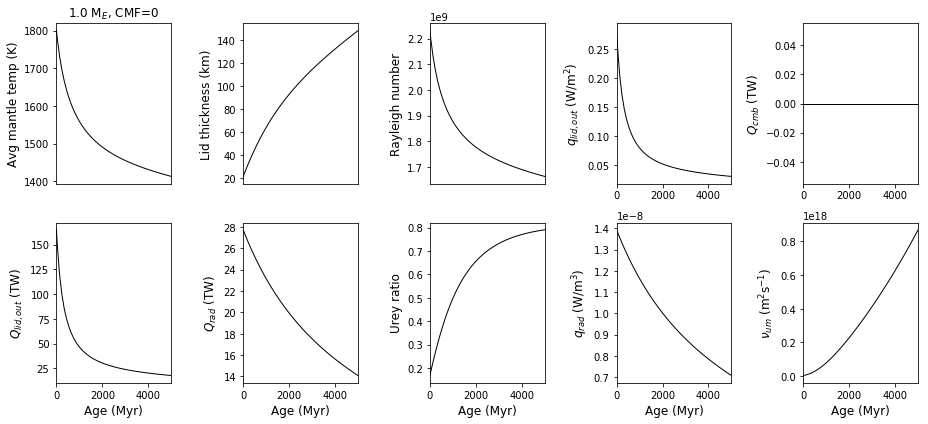

In [39]:
# run parameters in Earth units
M_p = 1 # M_E
a = 1 # au
CMF = 0
t_f = 5 # Gyr
T_m0 = 1800 # initial mantle temp in K

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, eta_0=eta_m, visc_type='Driscoll',
                 c_v=c_pm, #<----???
                 dT_core=dT_core, k_lm=k_lm)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=True, fend='', **varargs, **paramargs)


using Zeng radius model
SA_c 155169110302694.7
SA_p 517230367675649.06
R_p = 1.01 R_E
M_mantle 0.70 M_E
g_sfc = 9.68 m s^-2
CRF = 0.55
T_s = 737.00 K
Q_lid(t=0) = 1.73935431844e+15


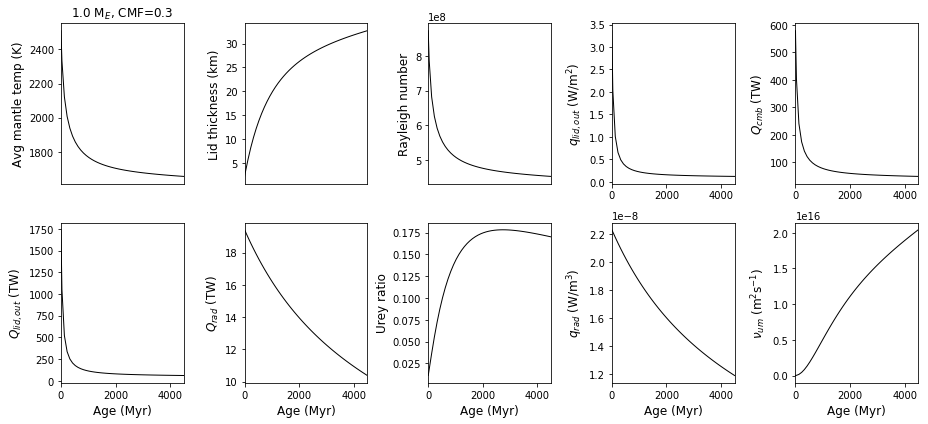

In [9]:
# reproduce Venus fig 6 for Driscoll
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
a = 0.72 # au
CMF = 0.3
t_f = 4.5 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737
paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm, T_s=T_s,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, eta_0=eta_m, visc_type='Driscoll',
                 c_v=c_pm, #<----???
                 dT_core=dT_core, k_lm=k_lm) 
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)
